## Neural networks for segmentation

In [1]:
! wget https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0 -O data.zip
! unzip -q data.zip

"wget" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
"unzip" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


Your next task is to train neural network to segment cells edges.

Here is an example of input data with corresponding ground truth:

In [1]:
import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import glob
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from albumentations import CLAHE, Compose, HorizontalFlip, Normalize, Transpose, RandomBrightnessContrast,\
                           RandomGamma, RandomRotate90, RandomSizedCrop, VerticalFlip
from albumentations.pytorch import ToTensor
from IPython import display
from torch.utils.data import DataLoader, Dataset
from tqdm import trange

import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

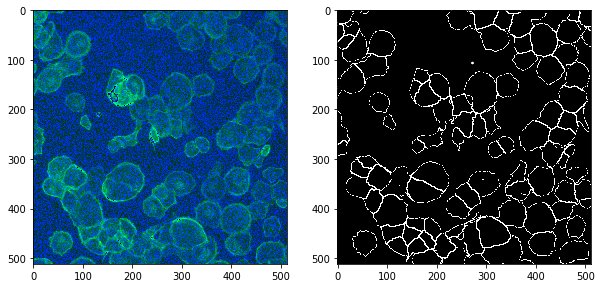

In [2]:
# Human HT29 colon-cancer cells
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = sp.misc.imread('BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp')
plt.imshow(im)
plt.subplot(1,2,2)
mask = sp.misc.imread('BBBC018_v1_outlines/train/00735-cells.png')
plt.imshow(mask, 'gray')

This time you aren't provided with any code snippets, just input data and target metric - intersection-over-union (IoU) (see implementation below).

You should train neural network to predict mask of edge pixels (pixels in gt images with value greater than 0).

Use everything you've learnt by now: 
* any architectures for semantic segmentation (encoder-decoder like or based on dilated convolutions)
* data augmentation (you will need that since train set consists of just 41 images)
* fine-tuning

You're not allowed to do only one thing: to train you network on test set.

Your final solution will consist of an ipython notebook with code (for final network training + any experiments with data) and an archive with png images with network predictions for test images (one-channel images, 0 - for non-edge pixels, any non-zero value for edge pixels).

Forestalling questions about baseline... well, let's say that a good network should be able to segment images with iou >= 0.29. This is not a strict criterion of full points solution, but try to obtain better numbers.

Practical notes:
* There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for "edge" class, or add class weights to increase the cost of edge pixels in optimized loss.
* Dataset is small so actively use data augmentation: rotations, flip, random contrast and brightness
* Better spend time on experiments with neural network than on postprocessing tricks (i.e test set augmentation).
* Keep in mind that network architecture defines receptive field of pixel. If the size of network input is smaller than receptive field of output pixel, than probably you can throw some layers without loss of quality. It is ok to modify "of-the-shelf" architectures. 

Good luck!

In [3]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

In [4]:
class CellDataset(Dataset):
    def __init__(self, images_dir='BBBC018_v1_images-fixed/', masks_dir='BBBC018_v1_outlines/', transform=None, mode='train'):
        self.images_dir = images_dir + mode
        self.masks_dir = masks_dir + mode
        self.images_list = glob.glob(self.images_dir + '/*')
        self.masks_list = glob.glob(self.masks_dir + '/*')
        self.transform = transform
        self.mode = mode
        assert mode in ['train', 'val', 'test']
         
            
    def __getitem__(self, idx):
        image = sp.misc.imread(self.images_list[idx])
        if self.mode != 'test':
            mask = sp.misc.imread(self.masks_list[idx])
            aug = self.transform(image=image, mask=mask)
            image_augmented = aug['image']
            mask_augmented = aug['mask']
            return image_augmented, mask_augmented
        else:
            image_file_name = os.path.splitext(os.path.basename(self.images_list[idx]))[0]
            return self.transform(image=image)['image'], self.masks_dir + '/' + image_file_name + '.png'
    

    def __len__(self):
        return len(self.images_list)


data_transform = {
    'train': Compose([
        RandomSizedCrop((256, 512), 512, 512, p=0.75),
        HorizontalFlip(p=0.75),
        VerticalFlip(p=0.75),
        Transpose(p=0.75),
        RandomRotate90(p=0.75),
        CLAHE(p=0.75),
        RandomBrightnessContrast(p=0.75),
        RandomGamma(p=0.75),
        Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ToTensor()
    ]),
    'val': Compose([
        Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ToTensor()
    ]),
    'test': Compose([
        Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ToTensor()
    ]),
}

In [5]:
dataset_train = CellDataset(transform=data_transform['train'], mode='train')
dataset_val = CellDataset(transform=data_transform['train'], mode='val')
train_loader = DataLoader(dataset_train, batch_size=1, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=1, shuffle=False)

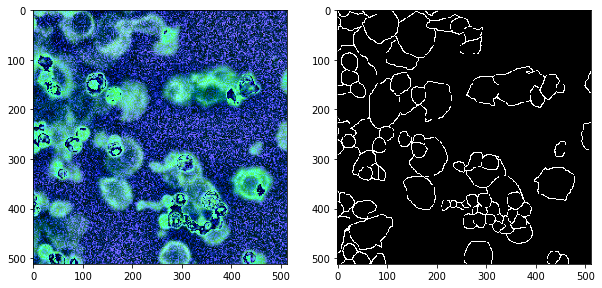

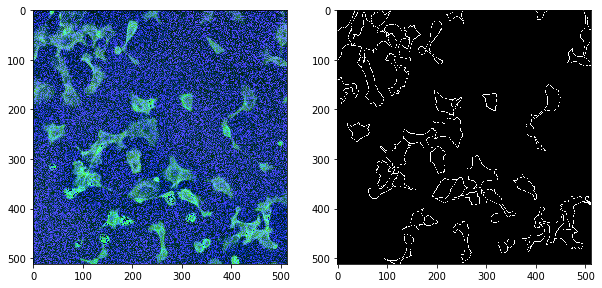

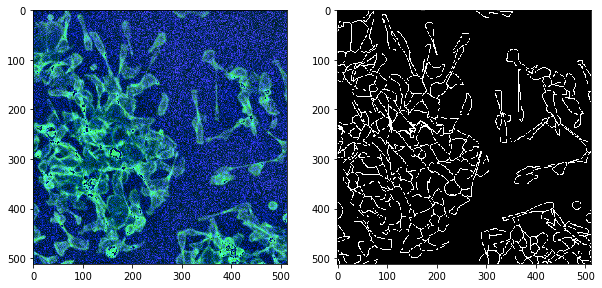

In [6]:
def scaled(x):
    return (x - x.min()) / (x.max() - x.min())

i = 0
for X, M in train_loader:
    plt.figure(figsize=(10,8))
    plt.subplot(1,2,1)
    plt.imshow(scaled(X.numpy()[0].transpose((1, 2, 0))))
    plt.subplot(1,2,2)
    plt.imshow(M.numpy()[0][0], 'gray')
    i += 1
    if i == 3:
        break

In [7]:
# https://www.kaggle.com/windsurfer/baseline-u-net-on-pytorch
# Implementation from https://github.com/timctho/unet-pytorch/
class UNet_down_block(torch.nn.Module):
    def __init__(self, input_channel, output_channel, down_size):
        super(UNet_down_block, self).__init__()
        self.conv1 = torch.nn.Conv2d(input_channel, output_channel, 3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(output_channel)
        self.conv2 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(output_channel)
        self.conv3 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(output_channel)
        self.max_pool = torch.nn.MaxPool2d(2, 2)
        self.relu = torch.nn.ReLU()
        self.down_size = down_size

    def forward(self, x):
        if self.down_size:
            x = self.max_pool(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        return x

class UNet_up_block(torch.nn.Module):
    def __init__(self, prev_channel, input_channel, output_channel):
        super(UNet_up_block, self).__init__()
        self.up_sampling = torch.nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv1 = torch.nn.Conv2d(prev_channel + input_channel, output_channel, 3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(output_channel)
        self.conv2 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(output_channel)
        self.conv3 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(output_channel)
        self.relu = torch.nn.ReLU()

    def forward(self, prev_feature_map, x):
        x = self.up_sampling(x)
        x = torch.cat((x, prev_feature_map), dim=1)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        return x


class UNet(torch.nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.down_block1 = UNet_down_block(3, 16, False)
        self.down_block2 = UNet_down_block(16, 32, True)
        self.down_block3 = UNet_down_block(32, 64, True)
        self.down_block4 = UNet_down_block(64, 128, True)
        self.down_block5 = UNet_down_block(128, 256, True)
        self.down_block6 = UNet_down_block(256, 512, True)
        self.down_block7 = UNet_down_block(512, 1024, True)

        self.mid_conv1 = torch.nn.Conv2d(1024, 1024, 3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(1024)
        self.mid_conv2 = torch.nn.Conv2d(1024, 1024, 3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(1024)
        self.mid_conv3 = torch.nn.Conv2d(1024, 1024, 3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(1024)

        self.up_block1 = UNet_up_block(512, 1024, 512)
        self.up_block2 = UNet_up_block(256, 512, 256)
        self.up_block3 = UNet_up_block(128, 256, 128)
        self.up_block4 = UNet_up_block(64, 128, 64)
        self.up_block5 = UNet_up_block(32, 64, 32)
        self.up_block6 = UNet_up_block(16, 32, 16)

        self.last_conv1 = torch.nn.Conv2d(16, 16, 3, padding=1)
        self.last_bn = torch.nn.BatchNorm2d(16)
        self.last_conv2 = torch.nn.Conv2d(16, 1, 1, padding=0)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        self.x1 = self.down_block1(x)
        self.x2 = self.down_block2(self.x1)
        self.x3 = self.down_block3(self.x2)
        self.x4 = self.down_block4(self.x3)
        self.x5 = self.down_block5(self.x4)
        self.x6 = self.down_block6(self.x5)
        self.x7 = self.down_block7(self.x6)
        self.x7 = self.relu(self.bn1(self.mid_conv1(self.x7)))
        self.x7 = self.relu(self.bn2(self.mid_conv2(self.x7)))
        self.x7 = self.relu(self.bn3(self.mid_conv3(self.x7)))
        x = self.up_block1(self.x6, self.x7)
        x = self.up_block2(self.x5, x)
        x = self.up_block3(self.x4, x)
        x = self.up_block4(self.x3, x)
        x = self.up_block5(self.x2, x)
        x = self.up_block6(self.x1, x)
        x = self.relu(self.last_bn(self.last_conv1(x)))
        x = self.last_conv2(x)
        return x

In [8]:
def set_random_seeds(seed_value=13, device='cpu'):
    '''source https://forums.fast.ai/t/solved-reproducibility-where-is-the-randomness-coming-in/31628/5'''
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    random.seed(seed_value)
    if device != 'cpu': 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

train_size = len(train_loader.dataset)
val_size = len(val_loader.dataset)

def train(model, optimizer, PATH, epochs_n=20, batch_size=1):
    model.to(device)
    
    train_loss_curve = [np.nan] * epochs_n
    val_loss_curve = [np.nan] * epochs_n
    train_iou_curve = [np.nan] * epochs_n
    val_iou_curve = [np.nan] * epochs_n
    max_val_iou = 0
    max_val_iou_epoch = 0

    n_batches_train = (train_size - 1) // batch_size + 1
    n_batches_val = (val_size - 1) // batch_size + 1
    
    for epoch in trange(epochs_n):
        model.train()

        train_loss_curve[epoch] = 0
        train_iou_curve[epoch] = 0
        for x, m in train_loader:
            x = x.to(device)
            m = m.to(device)
            optimizer.zero_grad()
            prediction = model(x)

            labels_pred = (prediction > 0).float()
            train_iou_curve[epoch] += calc_iou(labels_pred.cpu().detach().numpy(), m.cpu().detach().numpy())
            
            loss = criterion(prediction, m)
            train_loss_curve[epoch] += loss.item()
            loss.backward()
            optimizer.step()
        
        train_iou_curve[epoch] /= n_batches_train

        display.clear_output(wait=True)
        f, axes = plt.subplots(1, 2, figsize=(15, 3))

        train_loss_curve[epoch] /= n_batches_train
        axes[0].plot(train_loss_curve, label='train')

        model.eval()

        val_loss_curve[epoch] = 0
        val_iou_curve[epoch] = 0
        for x, m in val_loader:
            x = x.to(device)
            m = m.to(device)
            prediction = model(x)
            
            labels_pred = (prediction > 0).float()
            val_iou_curve[epoch] += calc_iou(labels_pred.cpu().detach().numpy(), m.cpu().detach().numpy())

            loss = criterion(prediction, m)
            val_loss_curve[epoch] += loss.item()
        
        val_iou_curve[epoch] /= n_batches_val
        val_loss_curve[epoch] /= n_batches_val
        axes[0].plot(val_loss_curve, label='val')
        axes[0].set_title('Loss: train {:.4f}, val {:.4f}'.format(train_loss_curve[epoch], val_loss_curve[epoch]))
        axes[0].legend()
        
        val_iou = val_iou_curve[epoch]
        if val_iou > max_val_iou:
            max_val_iou = val_iou
            max_val_iou_epoch = epoch
        torch.save(model.state_dict(), PATH)
        
        axes[1].set_title('IoU: train {:.4f}, val {:.4f}'.format(train_iou_curve[epoch], val_iou))
        axes[1].plot(train_iou_curve, label='train')
        axes[1].plot(val_iou_curve, label='val')
        axes[1].legend()

        plt.tight_layout()
        plt.show()
    
    print('Best val IoU: {:.4f}, epoch {}'.format(max_val_iou, max_val_iou_epoch))

In [9]:
class LossBinary:
    """
     Implementation from  https://github.com/ternaus/robot-surgery-segmentation
    """

    def __init__(self, jaccard_weight=0, eps=1e-15):
        self.nll_loss = nn.BCEWithLogitsLoss()
        self.jaccard_weight = jaccard_weight
        self.eps = eps

    def __call__(self, outputs, targets):
        loss = self.nll_loss(outputs, targets)
        if self.jaccard_weight:
            jaccard_target = targets
            jaccard_output = F.sigmoid(outputs)

            intersection = (jaccard_output * jaccard_target).sum()
            union = jaccard_output.sum() + jaccard_target.sum()
            loss -= self.jaccard_weight * torch.log((intersection + self.eps) / (union - intersection + self.eps))
        return loss

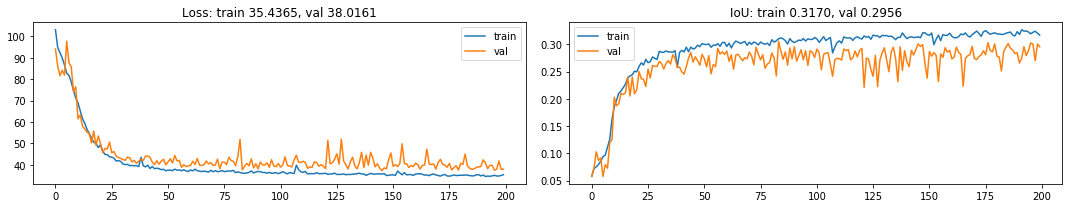

100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [1:05:38<00:00, 19.69s/it]


Best val IoU: 0.3057, epoch 83


In [10]:
epochs_n = 200

unet = UNet().to(device)
criterion = LossBinary(jaccard_weight=30)

opt = torch.optim.Adam(unet.parameters(), lr=0.0005)

PATH = 'models/UNet_final.pt'
set_random_seeds(device=device)
train(unet, opt, PATH=PATH, epochs_n=epochs_n, batch_size=1)

In [11]:
PATH = 'models/UNet_final.pt'
unet.load_state_dict(torch.load(PATH))
unet.eval()

UNet(
  (down_block1): UNet_down_block(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu): ReLU()
  )
  (down_block2): UNet_down_block(
    (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, af

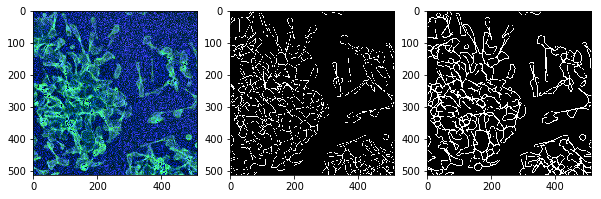

In [12]:
plt.figure(figsize=(10,8))
plt.subplot(1,3,1)
plt.imshow(scaled(X.numpy()[0].transpose((1, 2, 0))))
plt.subplot(1,3,2)
plt.imshow(M[0][0], 'gray')
plt.subplot(1,3,3)
plt.imshow((unet(X.cuda()).cpu().detach().numpy())[0][0] > 0, 'gray')

In [13]:
dataset_test = CellDataset(transform=data_transform['test'], mode='test')
test_loader = DataLoader(dataset_test, batch_size=1, shuffle=False)

In [14]:
for x, mask_path in test_loader:
    x = x.to(device)
    prediction = unet(x)
    labels_pred = (prediction > 0).float()
    plt.imsave(mask_path[0], labels_pred.cpu().detach().numpy()[0][0], cmap='gray')